In [1]:
import os 
from dotenv import load_dotenv   

from typing import Annotated     
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from agent import Config
import sys 
sys.path.append('../')
from helper import get_paths

In [10]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

config = Config()
llm = config.llm

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

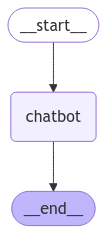

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass

### Agent Workflow:
- base level: USER_QUERY -> SQL Agent (input query, output data) -> Analytics Agent (input query, table, output result)
- SQL Agent: user query -> TABLES -> JOINS -> compile
    - TABLES: access to schema, few shot examples, creates json, then validated, then goes back if fails 
    - JOINS: same 
    - compile: compiles and executes

### SQL Workflow 

For now we will make a langgraph application that takes in a user query concerning some data analytics, then generates/executes a SQL query. To be simple I'll use basic agent workflow, rather than the more recent json versions I have.

In [4]:
config = Config()
llm    = config.llm
db     = config.db
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM ohlc LIMIT 1;")

sqlite
['fxrates', 'ohlc', 'treasury_yields']


"[('2020-01-01 00:00:00', 97.84704724718776, 122.24383711340477, 55.44555344062485, 92.24425183108863)]"

In [5]:
user_query = '''For the day with the lowest ratio of 5y tsy yield to 10y tsy yield among days where USD to GBP was greater than 0.75, calculate the percentage difference between the EUR equivalent of the close price and the JPY equivalent of the open price in the ohlc table.'''
user_query

'For the day with the lowest ratio of 5y tsy yield to 10y tsy yield among days where USD to GBP was greater than 0.75, calculate the percentage difference between the EUR equivalent of the close price and the JPY equivalent of the open price in the ohlc table.'

In [6]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode

def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [7]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(f"List tables tool:\n{list_tables_tool.invoke('')}")
print(f"Get Schema Tool:\n{get_schema_tool.invoke('ohlc')}")

List tables tool:
fxrates, ohlc, treasury_yields
Get Schema Tool:

CREATE TABLE ohlc (
	date TIMESTAMP, 
	open REAL, 
	high REAL, 
	low REAL, 
	close REAL
)

/*
3 rows from ohlc table:
date	open	high	low	close
2020-01-01 00:00:00	97.84704724718776	122.24383711340477	55.44555344062485	92.24425183108863
2020-01-02 00:00:00	92.1025462060139	123.51768361972003	66.15905516369102	95.32120830941909
2020-01-03 00:00:00	106.36100005515581	128.19239423274277	55.33471311840124	86.26686713329055
*/


In [8]:
from langchain_core.tools import tool

@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM ohlc LIMIT 10;"))

[('2020-01-01 00:00:00', 97.84704724718776, 122.24383711340477, 55.44555344062485, 92.24425183108863), ('2020-01-02 00:00:00', 92.1025462060139, 123.51768361972003, 66.15905516369102, 95.32120830941909), ('2020-01-03 00:00:00', 106.36100005515581, 128.19239423274277, 55.33471311840124, 86.26686713329055), ('2020-01-06 00:00:00', 80.81369705607382, 125.60013685719203, 50.78108336998327, 109.1217457076581), ('2020-01-07 00:00:00', 110.7078607823112, 125.85787783483124, 52.01795215193146, 116.74164452652454), ('2020-01-08 00:00:00', 83.42638881775606, 122.41280840799715, 52.81272810373951, 84.38937346958053), ('2020-01-09 00:00:00', 89.8622357484273, 121.05590796812594, 65.22239458043227, 115.18077316792039), ('2020-01-10 00:00:00', 82.98999653792121, 129.19575008359578, 55.89132254089701, 103.79690865194232), ('2020-01-13 00:00:00', 81.14335739717193, 121.60341479943946, 62.63162635281664, 119.59260717866489), ('2020-01-14 00:00:00', 114.10462164114534, 125.37346406189475, 69.31098577947

### SQL Agent Workflow:
- base level: 
    - inputs: Config := (llm, db), user query 
    - outputs: result 
    - steps: sql agent -> analytics agent:
    - sql agent:
        - inputs: Config, user query 
        - outputs: table
        - steps: gen_tables -> gen_joins -> compile -> execute 
        - gen_tables: 
            - inputs: Config, user query
            - outputs: table info
                - table info: {table: [(col, alias), ...], ...}
            - steps: context -> json_initial -> validate + rewrite -> json
            - context: schema, few shot examples, instructions, user query
            - validate: 
                - inputs: user query, json_initial
                - outputs: bool (if valid), error msg 
                - steps: simple validation -> ai validation
                - simple validation:
                    - steps: check_tables_exist -> check_cols_exist 
                - ai validation:
                    - steps: check_cols_make_sense -> check_names_make_sense
            - rewrite:
                - add error msg + json_initial + context, put through sql agent
                - add fail counter and increment, hard stop at self.num_attempts = 3 tries 
        - gen_joins:
            - inputs: Config, user query, table info
            - outputs: joins_info 
                - joins_info: inner(A, outer(B, C))
            - steps: context -> json_initial -> validate + rewrite -> json
            - ...
            - simple_validation: 
                - steps: check_tables/cols_exist -> check json_form -> check n-1 joins 
            - ai validation:
                - steps: check_joins_make_sense -> check_keeps_make_sense 
        - compile/execute:
            - inputs: table_info, joins_info
            - outputs: sql query
            - steps:
                - compile function -> execute sql  
    - analytics agent:
        - inputs: Config, user query, table 
        - outputs: result 
        - 

USER_QUERY -> SQL Agent (input query, output table) -> Analytics Agent (input query, table, output result)

- SQL Agent: user query -> TABLES -> JOINS -> compile
    - TABLES: access to schema, few shot examples, creates json, then validated, then goes back if fails 
    - JOINS: same 
    - compile: compiles and executes

### json formulater 

LabeledExample:
- user query, tables, joins, json template

JSONTemplate:
- tables, cols, aliases 


In [9]:
class LabeledExample:

    def __init__(
        self,
        user_query,
        table_info,
        joins_info
        ):
        self.user_query = user_query
        self.table_info = table_info
        self.joins_info = joins_info


user_query = '''For the day with the lowest ratio of 5y tsy yield to 10y tsy yield among days where USD to GBP was greater than 0.75, calculate the percentage difference between the EUR equivalent of the close price and the JPY equivalent of the open price in the ohlc table.'''
print(user_query)
table_info = {
    "treasury_yields" : [('date', 'yield_date'), ('yield_5_year', 'yield_5y_tsy'), ('yield_10_year', 'yield_10y_tsy')],
    "fxrates" : [("date", "fx_date"), ("usd_to_gdp", "usd_to_gdp"), ("usd_to_eur", "usd_to_eur"), ("usd_to_jpy", "usd_to_jpy")],
    "ohlc" : [("date", "ohlc_date"), ("open", "stock_open"), ("close", "stock_close")]
    }


For the day with the lowest ratio of 5y tsy yield to 10y tsy yield among days where USD to GBP was greater than 0.75, calculate the percentage difference between the EUR equivalent of the close price and the JPY equivalent of the open price in the ohlc table.
